## Removing Column Krater Handles

### Plan:

1. Using the _Marching Squares Method_, find all the contours.
1. Label the longest contour as the contour depicting the pot ouline.
1. Find the contour showing the handle of the pot (either left or right).
    - Get a list of the top 20 longest contours.
    - Set up an allowable region for the handle to fall within.
    - Select the furthermost contour, within that range, from the top 20 list, as the handle contour.
1. If the left handle was found. Then limit outline contour, to that just of the left side. (Else, the right side should be used).
1. Find the innermost side of the handle contour.
1. Compute the shortest distance between the top of the handle contour, to the lid of the pot. Label that point on the lid as $p_{1}$.
1. Given a range, look for points on the pot outline that stick out. We assume that these points will show the handle of the pot. Label the point on the pot outline, that shows the bottom of the handle, as $p_{2}$.
1. Starting from the middle of the pot lid, travel along the pot outline contour until you get to $p_{1}$. From here, cut to the start of the handle contour and continue until the end. From the end of the handle contour, cut to point $p_{2}$. Then continue traversing the pot contour outline until reaching the end.

### Code:

#### Imports

In [3]:
import matplotlib.pyplot as plt 
import numpy as np
import pylab as pl
from math import sqrt
from skimage.filters import threshold_otsu
from skimage import measure
import os
import re
import itertools as it
import csv
from PIL import Image
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
pl.ion()

#### Contour Outline Function

In [49]:
def get_outline_contour(img):
    
    # Get all contours:
    thresh = threshold_otsu(img)
    binary = img > thresh
    cont = measure.find_contours(binary, 0.8)
    
    # Find longest contour:
    cont_ln = []
    for n, contour in enumerate(cont):
        cont_ln.append(len(contour))

    longest_c = sorted(cont_ln,reverse=True)[:20]
    long_ind = []
    for i in range(0,len(cont_ln)):
        if cont_ln[i] in longest_c:
            long_ind.append(i)
            
    cl = cont[long_ind[0]]
        
    x = np.round(cl[:,1])
    cl_ub = min(x) + ((max(x)-min(x))/4)
    cl_lb = max(x) - ((max(x)-min(x))/4)
    cl_lb = cl_ub - int((cl_ub - min(x))/4)
    #cl_rng = list(range(cl_lb,cl_ub))

    y = np.round(cl[:,0])
    cl_ub_y = int(min(y) + ((max(y) - min(y))/4))
    cl_lb_y = int(min(y) + ((max(y) - min(y))/12))
    #cl_rng_y = list(range(cl_lb_y,cl_ub_y))
    
    hnd_conts_l = []
    hnd_conts_r = []
    x_furthest_l = []
    x_furthest_r = []
    for i in long_ind:
        c = cont[i]
        x = c[:,1]
        y = c[:,0]
        if max(x) < cl_ub and cl_lb_y < max(y) < cl_ub_y and cl_lb_y < min(y) < cl_ub_y:
            hnd_conts_l.append(i)
            x_furthest_l.append(max(x))
        if min(x) > cl_lb and cl_lb_y < max(y) < cl_ub_y and cl_lb_y < min(y) < cl_ub_y:
            hnd_conts_r.append(i)
            x_furthest_r.append(min(x))
            

    a = np.argmin(np.array(x_furthest_l))
    b = np.argmax(np.array(x_furthest_r))
            
    return cont[long_ind[0]],cont[hnd_conts_l[a]],cont[hnd_conts_r[b]]

#### Handle Removal Code:

In [54]:
def get_shortest_side(X,Y):
    top_pnt = np.argmax(Y)
    bot_pnt = np.argmin(Y)

    mx_pnt = max(top_pnt,bot_pnt)
    mn_pnt = min(top_pnt,bot_pnt)

    xs1 = list(X[mn_pnt:mx_pnt])
    ys1 = list(Y[mn_pnt:mx_pnt])

    xs2 = list(X)[mx_pnt:] + list(X)[:mn_pnt] 
    ys2 = list(Y)[mx_pnt:] + list(Y)[:mn_pnt] 
    
    if min(xs1) > min(xs2):
        D1 = "R"
        D2 = "L"
    else:
        D1 = "L"
        D2 = "R"

    if len(ys1) >= len(ys2):
        ys = ys2
        xs = xs2
        D = D2
    else:
        ys = ys1
        xs = xs1
        D = D1

    return xs,ys,D

In [74]:
def smooth_side_contour(x,y,direction):
    
    ys = sorted(y)
    ys = np.unique(np.round(ys))
    y = np.round(y)
    x = np.round(x)
        
    xs = []
    for i in range(0,len(ys)):
        inds = np.where(y==ys[i])
        xy = x[inds]
        if direction == 'R':
            xs.append(max(xy))
        else:
            xs.append(min(xy))
            
    return xs,ys

In [62]:
def get_top_bot_handle(x_,y_):

    mx = np.argmax(y_)
    mn = np.argmin(y_)
    ubt = np.max(y_)
    lbb = np.min(y_)
    ubb = ubt - ((ubt - lbb)/10)
    lbt = lbb + ((ubt - lbb)/10)

    bot = []
    top = []

    for i in range(0,len(x_)):
        if lbb <= y_[i] <= lbt:
            bot.append(i)
        if ubb <= y_[i] <= ubt:
            top.append(i)
    return top,bot

In [70]:
def get_handle_side(x_,y_,top,bot,D):
    if D == "L":
        p1 = np.argmin(x_[top])
        p2 = np.argmin(x_[bot])
    else:
        p1 = np.argmax(x_[top])
        p2 = np.argmax(x_[bot])
    

    p1 = top[p1]
    p2 = bot[p2]

    # Determine direction of contour.
    d_ = "L"
    if (x_[p2] > x_[p2-1]) or (x_[p2] > x_[p2-2]):
        d_ = "R"

    xh = []
    yh = []

    x_2 = list(x_)
    y_2 = list(y_)

    # Case 1:
    if (d_ == "R" and D == "L") or (d_ =="L" and D == "R"):
        if p1 > p2:
            xh = x_2[p2:p1]
            yh = y_2[p2:p1]
        else:
            xh = x_2[p2:]
            xh.extend(x_2[0:p1])
            yh = y_2[p2:]
            yh.extend(y_2[0:p1])
    # Case 2:        
    elif (d_ == "L" and D == "L") or (d_ =="R" and D == "R"):
        if p1 > p2:
            xh = x_2[p1:]
            xh.extend(x_2[0:p2])
            yh = y_2[p1:]
            yh.extend(y_2[0:p2])
        else:
            xh = x_2[p1:p2]
            yh = y_2[p1:p2]
    
    return xh,yh

In [88]:
def get_ckrater_contour(img):
    
    # 1) Get pot and handle contours:
    pot,h_l,h_r = get_outline_contour(img)
    
    # 2) Get shortest side of outline:
    x = pot[:,1]
    y = pot[:,0]
    x_,y_,D = get_shortest_side(x,y)
    
    # 3) Make contour side smoother:
    xs,ys = smooth_side_contour(x_,y_,D)
    
    # 4) Get side of handle:
    if D == "R":
        xh = h_r[:,1]
        yh = h_r[:,0]
    else:
        xh = h_l[:,1]
        yh = h_l[:,0]
        
    top,bot = get_top_bot_handle(xh,yh)
    xh,yh = get_handle_side(xh,yh,top,bot,D)
    
    #5) Find points to make the cut:

    if D == "R":
        p1 = np.where(xs > max(xh))[0][0]
    else:
        p1 = np.where(xs < min(xh))[0][0]
    
    p1 = p1+1
    
    p2 = np.where(ys > max(yh))[0][0]

    
    #6) Make the cut:
    # Check direction of handle contour first and sort accordingly.
    if yh[0] > yh[round(len(yh)/2)]:
        yh.reverse()
        xh.reverse()
        
    xr = []
    yr = []
    xr.extend(xs[:p1])
    yr.extend(ys[:p1])
    xr.extend(xh)
    yr.extend(yh)
    xr.extend(xs[p2:])
    yr.extend(ys[p2:])
            
    return xr,yr

#### Test:

In [12]:
image_grey = data.load('C:\\Users\\arian\\Dropbox\\arianna_phd\\Pots\\Original_Images\\colkrater_20578_London.bmp',as_gray=True)

In [86]:
x,y = get_ckrater_contour(image_grey)

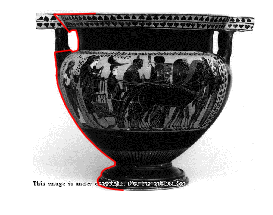

In [87]:
fig, ax = plt.subplots(figsize=(4, 6))

ax.imshow(image_grey, cmap="gray")
ax.set_axis_off()
ax.plot(x,y,'-r')